ANALISIS SENTIMEN BERITA PAJAK
LLM Gemma 3 + Naive Bayes/SVM + Indo-RoBERTa Fine-Tuned


In [ ]:
import os
import random
import numpy as np

# --- CONFIG ---
OPENROUTER_API_KEY = os.environ.get('OPENROUTER_API_KEY')
if not OPENROUTER_API_KEY:
    raise ValueError('OPENROUTER_API_KEY is not set')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# If using torch later, set seed when torch is available
try:
    import torch
    torch.manual_seed(SEED)
except Exception:
    pass


### Install Library

In [1]:
!pip install requests transformers datasets accelerate wordcloud torch scikit-learn seaborn joblib tqdm ipywidgets -q 

### Import & Konfigurasi

In [4]:
import requests
import json
import time
import pandas as pd
from tqdm.notebook import tqdm  # Untuk progress bar yang cantik

# --- KONFIGURASI ---
# Masukkan API Key OpenRouter Anda di sini
# OPENROUTER_API_KEY is read from environment
OPENROUTER_API_KEY = os.environ.get("OPENROUTER_API_KEY")

# Nama File
INPUT_CSV = "combined_data.csv"
OUTPUT_CSV = "combined_data_labeled.csv"

# Model yang digunakan (Free)
MODEL_NAME = "google/gemma-3-27b-it:free"

Load Data & Preview

In [5]:
# Load dataset
try:
    df = pd.read_csv(INPUT_CSV)
    
    # Isi data kosong dengan string kosong agar tidak error saat diproses
    df['title'] = df['title'].fillna('')
    df['full_content'] = df['full_content'].fillna('')
    
    print(f"[+] Data berhasil dimuat. Total baris: {len(df)}")
    display(df[['title', 'full_content']].head(3))
    
except FileNotFoundError:
    print(f"[!] Error: File '{INPUT_CSV}' tidak ditemukan.")

[+] Data berhasil dimuat. Total baris: 1174


,title,full_content
0,"Coretax Beroperasi, Pengusaha RI Kena Pajak Ta...","Coretax Beroperasi, Pengusaha RI Kena Pajak Ta..."
1,Coretax dan Tantangan Modernisasi Pajak: Kemud...,Coretax dan Tantangan Modernisasi Pajak: Kemud...
2,Usut Dugaan Korupsi Pembayaran Pajak Periode 2...,Usut Dugaan Korupsi Pembayaran Pajak Periode 2...


Definisi Fungsi Request ke LLM

In [24]:
def get_article_sentiment(title, text):
    """
    Mengirim judul dan isi artikel ke LLM untuk analisis sentimen.
    Output: Positif, Negatif, atau Netral.
    """
    # 1. Optimasi Input: Gabungkan Judul + 1500 karakter pertama artikel
    # Berita biasanya intinya ada di awal (lead paragraf)
    full_input = f"Judul: {title}\nIsi: {str(text)[:1500]}..." 

    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
        "HTTP-Referer": "https://localhost:8888",
        "X-Title": "News Sentiment Analysis",
    }

    # 2. System Prompt: Persona Analis Ekonomi/Pajak
    system_prompt = (
        "Anda adalah analis sentimen berita ekonomi dan kebijakan publik. "
        "Tugas: Tentukan sentimen artikel ini terhadap topik utama (Pajak/Pemerintah/Ekonomi). "
        "Kategori: 'Positif' (Optimis/Mendukung/Berita Baik), 'Negatif' (Pesimis/Kritik/Berita Buruk), atau 'Netral' (Informatif/Datar). "
        "Jawab HANYA satu kata labelnya."
    )

    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": full_input}
        ],
        "temperature": 0.1, # Rendah agar jawaban konsisten
        "max_tokens": 10    # Hemat token
    }

    try:
        response = requests.post(url, headers=headers, data=json.dumps(payload), timeout=20)
        
        if response.status_code == 200:
            raw_label = response.json()['choices'][0]['message']['content'].strip()
            # Bersihkan jawaban (misal: "Sentimen: Positif." -> "Positif")
            clean_label = raw_label.replace('Sentimen:', '').replace('.', '').strip().capitalize()
            # Validasi output agar sesuai kategori
            if clean_label not in ['Positif', 'Negatif', 'Netral']:
                return "Netral" # Fallback jika LLM ngelantur
            return clean_label
        else:
            print(f"\n[!] API Error {response.status_code}")
            return "Error"
            
    except Exception as e:
        print(f"\n[!] Connection Error: {e}")
        return "Error"

Eksekusi Labeling (Utama)

In [25]:
# --- PENGATURAN ---
# Set True untuk tes 5 data pertama dulu. Set False untuk proses SEMUA data.
TEST_MODE = True

# Filter data
if TEST_MODE:
    print("[*] Mode Test: Hanya memproses 5 data pertama.")
    df_process = df.head(5).copy()
else:
    print(f"[*] Mode Full: Memproses seluruh {len(df)} data.")
    df_process = df.copy()

# Container hasil
results = []

print("[*] Memulai labeling dengan LLM...")

# Loop dengan progress bar
for index, row in tqdm(df_process.iterrows(), total=df_process.shape[0]):
    
    label = get_article_sentiment(row['title'], row['full_content'])
    results.append(label)
    
    # Delay 2 detik agar aman dari rate limit (PENTING untuk user gratis)
    time.sleep(2)

# Simpan hasil ke kolom baru
df_process['sentiment_llm'] = results

print("\n[+] Proses Selesai!")

[*] Mode Test: Hanya memproses 5 data pertama.
[*] Memulai labeling dengan LLM...


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Simpan & Analisis Hasil

In [26]:
# 1. Tampilkan Statistik Sentimen
print("--- Statistik Sentimen ---")
print(df_process['sentiment_llm'].value_counts())

# 2. Preview Data Hasil
print("\n--- Preview Hasil ---")
display(df_process[['title', 'sentiment_llm']].head())

# 3. Simpan ke CSV
# Jika TEST_MODE, kita simpan dengan nama beda agar file asli tidak tertimpa data sampel
if TEST_MODE:
    save_name = "sample_labeled_result.csv"
else:
    save_name = OUTPUT_CSV

df_process.to_csv(save_name, index=False)
print(f"\n[+] File berhasil disimpan ke: {save_name}")

--- Statistik Sentimen ---


Exception ignored in: <function tqdm.__del__ at 0x000001DE911D9D00>
Traceback (most recent call last):
  File "C:\Users\haxor\AppData\Roaming\Python\Python313\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\haxor\AppData\Roaming\Python\Python313\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


KeyError: 'sentiment_llm'

### Training Model

Import Library

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 

# Library Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("[+] Library berhasil di-load.")

[+] Library berhasil di-load.


Load Data Hasil Labeling LLM

In [7]:
# Ganti nama file jika berbeda
INPUT_FILE = "combined_data_labeled.csv"

try:
    df = pd.read_csv(INPUT_FILE)
    
    # 1. Filter hanya ambil kolom penting
    # Pastikan nama kolom 'sentiment_llm' sesuai dengan hasil step sebelumnya
    df_clean = df[['title', 'full_content', 'sentiment_llm']].copy()
    
    # 2. Bersihkan Data Kosong
    df_clean = df_clean.dropna(subset=['sentiment_llm'])
    
    # 3. Validasi Label (Hanya ambil yang valid)
    valid_labels = ['Positif', 'Negatif', 'Netral']
    df_clean = df_clean[df_clean['sentiment_llm'].isin(valid_labels)]
    
    print(f"[+] Data siap! Jumlah sampel valid: {len(df_clean)} baris")
    print("Sebaran Data:")
    print(df_clean['sentiment_llm'].value_counts())
    
except FileNotFoundError:
    print(f"[!] Error: File {INPUT_FILE} tidak ditemukan.")

[+] Data siap! Jumlah sampel valid: 1168 baris
Sebaran Data:
sentiment_llm
Netral     426
Negatif    413
Positif    329
Name: count, dtype: int64


Feature Engineering (Mengubah Teks jadi Angka)

In [8]:
# 1. Gabungkan Judul dan Isi agar konteks lebih kaya
df_clean['text_final'] = df_clean['title'].fillna('') + " " + df_clean['full_content'].fillna('')

# 2. Tentukan X (Fitur) dan y (Target)
X = df_clean['text_final']
y = df_clean['sentiment_llm']

# 3. Vectorization (TF-IDF)
# max_features=5000 artinya kita hanya mengambil 5000 kata terpenting/tersering muncul
vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.9)
X_vec = vectorizer.fit_transform(X)

# 4. Bagi Data (80% Latih, 20% Ujian)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

print(f"[+] Data dibagi: {X_train.shape[0]} data latih, {X_test.shape[0]} data uji.")

[+] Data dibagi: 934 data latih, 234 data uji.


Training & Kompetisi Model (NB vs SVM)

In [9]:
print("--- Memulai Training ---")

# 1. Model Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)

# 2. Model SVM (Support Vector Machine)
svm_model = LinearSVC(random_state=42, dual='auto')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

# 3. Bandingkan Hasil
print(f"Akurasi Naive Bayes : {nb_acc*100:.2f}%")
print(f"Akurasi SVM         : {svm_acc*100:.2f}%")

# Tentukan Pemenang
if svm_acc >= nb_acc:
    best_model = svm_model
    y_pred_best = svm_pred
    winner_name = "SVM"
else:
    best_model = nb_model
    y_pred_best = nb_pred
    winner_name = "Naive Bayes"

print(f"\n[!] Model Terbaik: {winner_name}")
print("\nDetail Laporan Klasifikasi:")
print(classification_report(y_test, y_pred_best))

--- Memulai Training ---
Akurasi Naive Bayes : 64.10%
Akurasi SVM         : 72.65%

[!] Model Terbaik: SVM

Detail Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.85      0.83      0.84        76
      Netral       0.60      0.75      0.67        79
     Positif       0.77      0.61      0.68        79

    accuracy                           0.73       234
   macro avg       0.74      0.73      0.73       234
weighted avg       0.74      0.73      0.73       234



Visualisasi Evaluasi

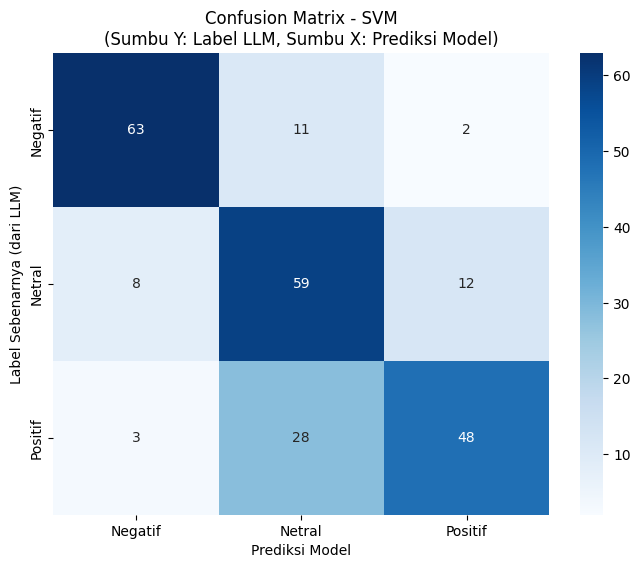

In [10]:
# Membuat Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title(f'Confusion Matrix - {winner_name}\n(Sumbu Y: Label LLM, Sumbu X: Prediksi Model)')
plt.ylabel('Label Sebenarnya (dari LLM)')
plt.xlabel('Prediksi Model')
plt.show()

Simpan Model (Export)

In [11]:
# Simpan 2 hal: Vectorizer (Kamus) dan Model (Otak)
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(best_model, 'sentiment_model_final.pkl')

print("[+] Model berhasil disimpan!")
print("    1. tfidf_vectorizer.pkl (Untuk mengubah teks baru jadi angka)")
print("    2. sentiment_model_final.pkl (Untuk memprediksi sentimen)")

[+] Model berhasil disimpan!
    1. tfidf_vectorizer.pkl (Untuk mengubah teks baru jadi angka)
    2. sentiment_model_final.pkl (Untuk memprediksi sentimen)


Simulasi Penggunaan (Test Manual)

In [12]:
# Load model (seolah-olah kita di production)
loaded_vec = joblib.load('tfidf_vectorizer.pkl')
loaded_model = joblib.load('sentiment_model_final.pkl')

# Masukkan contoh berita buatan sendiri
contoh_berita = [
    "Ekonomi Indonesia diprediksi tumbuh pesat tahun depan berkat hilirisasi",
    "Banyak PHK massal terjadi di sektor tekstil, buruh menjerit",
    "Pemerintah mengumumkan jadwal libur nasional tahun 2025"
]

# Prediksi
X_baru = loaded_vec.transform(contoh_berita)
hasil_prediksi = loaded_model.predict(X_baru)

print("--- Hasil Prediksi Model ---")
for teks, label in zip(contoh_berita, hasil_prediksi):
    print(f"Berita: '{teks}'\nSentimen: {label}\n")

--- Hasil Prediksi Model ---
Berita: 'Ekonomi Indonesia diprediksi tumbuh pesat tahun depan berkat hilirisasi'
Sentimen: Negatif

Berita: 'Banyak PHK massal terjadi di sektor tekstil, buruh menjerit'
Sentimen: Netral

Berita: 'Pemerintah mengumumkan jadwal libur nasional tahun 2025'
Sentimen: Negatif



## Training Advanced Model: Indo-RoBERTa (Deep Learning)

### 1. Install Library Tambahan

In [13]:
!pip install transformers datasets accelerate torch scikit-learn

Defaulting to user installation because normal site-packages is not writeable


### 2. Persiapan Data untuk RoBERTa

In [14]:
import torch
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [15]:
label_map = {'Negatif': 0, 'Netral': 1, 'Positif': 2}
id2label = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

In [16]:
df_roberta = df_clean.copy()

In [17]:
df_roberta['label'] = df_roberta['sentiment_llm'].map(label_map)

In [18]:
df_roberta = df_roberta.dropna(subset=['label'])
df_roberta['label'] = df_roberta['label'].astype(int)

In [19]:
train_df, test_df = train_test_split(df_roberta, test_size=0.2, random_state=42)

In [20]:
train_dataset = Dataset.from_pandas(train_df[['text_final', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text_final', 'label']])

print(f"[+] Data Siap untuk RoBERTa.")
print(f"    Train: {len(train_dataset)} baris")
print(f"    Test : {len(test_dataset)} baris")

[+] Data Siap untuk RoBERTa.
    Train: 934 baris
    Test : 234 baris


In [21]:
MODEL_CKPT = "w11wo/indonesian-roberta-base-sentiment-classifier"

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_function(examples):
    # Padding='max_length' memastikan panjang input seragam
    # Truncation=True memotong teks yang terlalu panjang (>128 token agar hemat memori)
    return tokenizer(examples["text_final"], padding="max_length", truncation=True, max_length=128)

print("[*] Melakukan Tokenisasi...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

print("[+] Tokenisasi Selesai.")

[*] Melakukan Tokenisasi...


Map:   0%|          | 0/934 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

[+] Tokenisasi Selesai.


In [23]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT, 
    num_labels=3, 
    id2label=id2label,
    label2id=label_map,
    ignore_mismatched_sizes=True # Wajib True karena kita menimpa output layer lama
)

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [25]:
# Setting Training Arguments
training_args = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=3,              # Loop belajar 3 kali
    per_device_train_batch_size=8,   # Batch kecil
    per_device_eval_batch_size=16,
    warmup_steps=50,                 # Pemanasan learning rate
    weight_decay=0.01,               # Regularisasi
    logging_dir='./logs',
    logging_steps=50,
    
    # --- PERBAIKAN DI SINI ---
    eval_strategy="epoch",           # GANTI 'evaluation_strategy' JADI 'eval_strategy'
    # -------------------------
    
    save_strategy="epoch",           # Simpan model tiap akhir epoch
    load_best_model_at_end=True,     # Ambil model terbaik di akhir
    learning_rate=2e-5,              # Learning rate standar
)

# Inisialisasi Trainer (Tetap sama)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

# MULAI TRAINING
print("[*] Memulai Training RoBERTa... (Mohon Tunggu)")
trainer.train()

[*] Memulai Training RoBERTa... (Mohon Tunggu)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.988400,0.785282,0.628205,0.626257,0.666498,0.628205
2,0.639100,0.799877,0.636752,0.639844,0.703052,0.636752
3,0.340800,0.719228,0.717949,0.719545,0.722184,0.717949


TrainOutput(global_step=351, training_loss=0.757614812959633, metrics={'train_runtime': 57.4401, 'train_samples_per_second': 48.781, 'train_steps_per_second': 6.111, 'total_flos': 184310949118464.0, 'train_loss': 0.757614812959633, 'epoch': 3.0})

In [26]:
save_path = "./my_fine_tuned_roberta"

print(f"[*] Menyimpan model ke {save_path}...")
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("[+] Berhasil disimpan!")

[*] Menyimpan model ke ./my_fine_tuned_roberta...
[+] Berhasil disimpan!


7. Test Prediksi (Inference)

In [27]:
from transformers import pipeline

# Load model local yang baru saja disimpan
classifier = pipeline("sentiment-analysis", model=save_path, tokenizer=save_path)

# Data uji manual
contoh_berita = [
    "Ekonomi Indonesia diprediksi tumbuh pesat tahun depan berkat hilirisasi",
    "Banyak PHK massal terjadi di sektor tekstil, buruh menjerit",
    "Pemerintah mengumumkan jadwal libur nasional tahun 2025"
]

print("--- Hasil Prediksi RoBERTa (Custom Fine-Tuned) ---")
results = classifier(contoh_berita)

for teks, res in zip(contoh_berita, results):
    label = res['label']
    score = res['score']
    print(f"Berita   : {teks}")
    print(f"Prediksi : {label} (Keyakinan: {score:.4f})\n")

Device set to use cuda:0


--- Hasil Prediksi RoBERTa (Custom Fine-Tuned) ---
Berita   : Ekonomi Indonesia diprediksi tumbuh pesat tahun depan berkat hilirisasi
Prediksi : Negatif (Keyakinan: 0.6661)

Berita   : Banyak PHK massal terjadi di sektor tekstil, buruh menjerit
Prediksi : Negatif (Keyakinan: 0.7635)

Berita   : Pemerintah mengumumkan jadwal libur nasional tahun 2025
Prediksi : Netral (Keyakinan: 0.9956)



sentiment_llm
Netral     426
Negatif    413
Positif    329
Name: count, dtype: int64


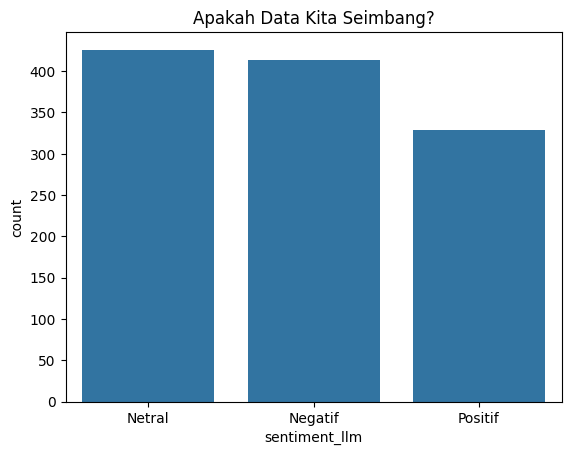

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cek jumlah per label
print(df_clean['sentiment_llm'].value_counts())

# Visualisasi
sns.countplot(x='sentiment_llm', data=df_clean)
plt.title("Apakah Data Kita Seimbang?")
plt.show()

[*] Melakukan prediksi pada data test...



--- Detail Performa RoBERTa ---
              precision    recall  f1-score   support

     Negatif       0.82      0.78      0.80        76
      Netral       0.62      0.67      0.65        79
     Positif       0.73      0.71      0.72        79

    accuracy                           0.72       234
   macro avg       0.72      0.72      0.72       234
weighted avg       0.72      0.72      0.72       234



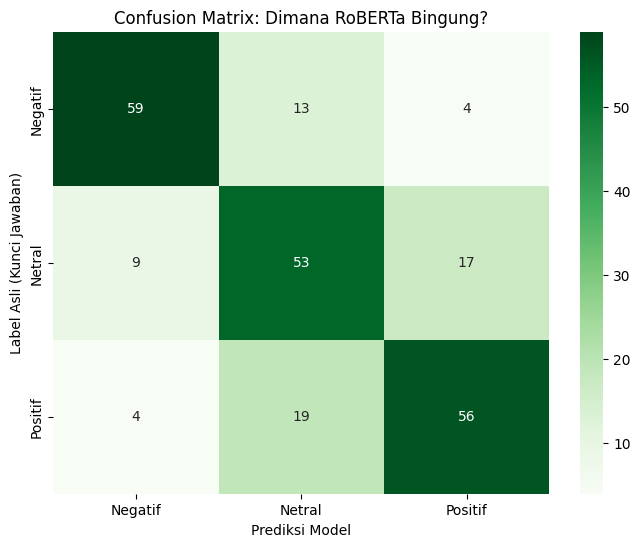

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. Lakukan Prediksi pada Data Test (20% data yang disisihkan tadi)
print("[*] Melakukan prediksi pada data test...")
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# 2. Buat Laporan Angka (Precision/Recall)
print("\n--- Detail Performa RoBERTa ---")
# Target names harus urut: 0=Negatif, 1=Netral, 2=Positif
print(classification_report(labels, preds, target_names=['Negatif', 'Netral', 'Positif']))

# 3. Visualisasi Confusion Matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Kunci Jawaban)')
plt.title('Confusion Matrix: Dimana RoBERTa Bingung?')
plt.show()

In [30]:
# --- ERROR ANALYSIS ---
# Mari kita lihat teks mana yang Label aslinya BUKAN Netral, tapi ditebak Netral

# Ambil prediksi dan label asli
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Konversi kembali ke DataFrame agar mudah dibaca
df_test_view = test_df.copy().reset_index(drop=True)
df_test_view['prediksi_model'] = [id2label[x] for x in preds]
df_test_view['label_asli'] = [id2label[x] for x in labels]

# Filter: Tampilkan data yang SALAH TEBAK
df_salah = df_test_view[df_test_view['prediksi_model'] != df_test_view['label_asli']]

print(f"Jumlah Salah Tebak: {len(df_salah)} dari {len(df_test_view)} data")

# Tampilkan 5 kesalahan dimana Aslinya POSITIF tapi dibilang NETRAL
print("\n--- Kasus: Aslinya Positif, dibilang Netral (Model Kurang Peka) ---")
cases = df_salah[(df_salah['label_asli'] == 'Positif') & (df_salah['prediksi_model'] == 'Netral')]
for txt in cases['text_final'].head(5):
    print(f"- {txt[:150]}...")

# Tampilkan 5 kesalahan dimana Aslinya NEGATIF tapi dibilang NETRAL
print("\n--- Kasus: Aslinya Negatif, dibilang Netral (Model Cari Aman) ---")
cases = df_salah[(df_salah['label_asli'] == 'Negatif') & (df_salah['prediksi_model'] == 'Netral')]
for txt in cases['text_final'].head(5):
    print(f"- {txt[:150]}...")

Jumlah Salah Tebak: 66 dari 234 data

--- Kasus: Aslinya Positif, dibilang Netral (Model Kurang Peka) ---
- Apa Itu Coretax: Pengertian, Tujuan, dan Cara Mengaksesnya Apa Itu Coretax: Pengertian, Tujuan, dan Cara Mengaksesnya   JAKARTA, KOMPAS.com - Kementer...
- Cara Mengakses Coretax DJP, Portal untuk Seluruh Layanan Perpajakan - Kompas.com Cara Mengakses Coretax DJP, Portal untuk Seluruh Layanan Perpajakan  ...
- Ditjen Pajak Dukung Fatwa MUI Soal Pajak Berkeadilan Ditjen Pajak Dukung Fatwa MUI Soal Pajak Berkeadilan      DIREKTORAT Jenderal Pajak (DJP) Kemente...
- Apakah Pencairan BLT Kesra Rp900.000 di Kantor Pos Kena Potongan Pajak? Apakah Pencairan BLT Kesra Rp900.000 di Kantor Pos Kena Potongan Pajak? : Okez...
- Panduan Lengkap Cara Mengubah Data Wajib Pajak di Coretax Panduan Lengkap Cara Mengubah Data Wajib Pajak di Coretax  Perubahan data wajib pajak, seper...

--- Kasus: Aslinya Negatif, dibilang Netral (Model Cari Aman) ---
- Apakah Indonesia Siap dengan Pajak Berbasis B

In [31]:
import torch

# 1. Simpan Model Final ke Folder
model_path = "./model_sentimen_pajak_v1"
print(f"[*] Menyimpan model final ke: {model_path} ...")

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print("[+] Model berhasil disimpan! Anda bisa zip folder ini untuk dipindah ke server lain.")

# --- SIMULASI PENGGUNAAN (INFERENCE) DI MASA DEPAN ---
# Anggap ini script terpisah (misal untuk bot telegram atau dashboard)

from transformers import pipeline

print("\n[*] Memuat model untuk prediksi data baru...")
# Load model dari folder yang barusan disimpan
my_classifier = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Contoh Berita Terbaru (Data Dummy)
berita_baru = [
    # "Penerimaan pajak bulan ini melampaui target APBN, prestasi gemilang.",
    # "Banyak keluhan wajib pajak terkait server down saat pelaporan SPT.",
    # "Jadwal sosialisasi undang-undang harmonisasi peraturan perpajakan.",
    # "KPK menyoroti adanya potensi kebocoran penerimaan negara."
    "Ekonomi Indonesia diprediksi tumbuh pesat tahun depan berkat hilirisasi",
    "Banyak PHK massal terjadi di sektor tekstil, buruh menjerit",
    "Pemerintah mengumumkan jadwal libur nasional tahun 2025"
]

print("\n--- HASIL ANALISIS SENTIMEN OTOMATIS ---")
results = my_classifier(berita_baru)

for text, res in zip(berita_baru, results):
    label = res['label']
    score = res['score']
    
    # Logika Bisnis Tambahan (Optional)
    # Jika model ragu-ragu (score < 0.6) dan labelnya Netral, kita tandai 'Perlu Review'
    status = label
    if label == 'Netral' and score < 0.6:
        status = "Netral (Ambigu/Perlu Cek)"
        
    print(f"Berita: {text[:60]}...")
    print(f"Label : {status} (Confidence: {score:.2%})\n")

[*] Menyimpan model final ke: ./model_sentimen_pajak_v1 ...


Device set to use cuda:0


[+] Model berhasil disimpan! Anda bisa zip folder ini untuk dipindah ke server lain.

[*] Memuat model untuk prediksi data baru...

--- HASIL ANALISIS SENTIMEN OTOMATIS ---
Berita: Ekonomi Indonesia diprediksi tumbuh pesat tahun depan berkat...
Label : Negatif (Confidence: 66.61%)

Berita: Banyak PHK massal terjadi di sektor tekstil, buruh menjerit...
Label : Negatif (Confidence: 76.35%)

Berita: Pemerintah mengumumkan jadwal libur nasional tahun 2025...
Label : Netral (Confidence: 99.56%)



Masih kurang akurat, mari kita kasih data injection!

In [32]:
# ==========================================
# LANGKAH PERBAIKAN: DATA INJECTION
# ==========================================
import pandas as pd

# 1. Buat Data Tambahan (Vitamin)
# Kita paksa model belajar pola-pola spesifik ini
data_tambahan = [
    # =====================================================
    # POSITIF KUAT (25 contoh - Prestasi/Naik/Sukses)
    # =====================================================
    ("Penerimaan pajak Januari 2024 capai Rp149,25 triliun, positif melebihi target.", "Positif"),
    ("Kanwil DJP Jakbar himpun penerimaan Rp42,29 triliun hingga Juli 2025, tumbuh 16,34%.", "Positif"),
    ("DJP Jaksel I bukukan Rp47 triliun hingga Juni 2025, tumbuh 11,05% year-on-year.", "Positif"),
    ("Coretax DJP sukses integrasikan 7 layanan dalam 1 aplikasi, tingkatkan efisiensi.", "Positif"),
    ("Pajak Bertutur 2025 investasi kesadaran pajak generasi muda berhasil dilaksanakan.", "Positif"),
    ("Kenaikan PPN optimalkan penerimaan negara dan stabilkan ekonomi nasional.", "Positif"),
    ("Indonesia terapkan Pajak Minimum Global, ciptakan iklim investasi kompetitif.", "Positif"),
    ("Rasio kepatuhan SPT 2024 capai 85,72%, melebihi target DJP 83,22%.", "Positif"),
    ("DJP Kalselteng 4 tahun berturut capai target penerimaan pajak APBN.", "Positif"),
    ("Penerimaan pajak Jabar III Rp16,84 triliun hingga Agustus 2025, tumbuh 4,2%.", "Positif"),
    ("Coretax tingkatkan kepatuhan formal 18% melalui aktivasi akun wajib pajak.", "Positif"),
    ("Prestasi DJP: Realisasi PPh 21 Rp28,3 triliun Januari 2024, tumbuh 18,9%.", "Positif"),
    ("Transformasi DJP melalui Coretax perwujudan 5 pilar reformasi sukses.", "Positif"),
    ("Wajib pajak sukses daftarkan NPWP mandiri melalui Coretax DJP.", "Positif"),
    ("Pajak minimum global cegah tax haven, sistem perpajakan lebih adil.", "Positif"),
    ("Tax Edu Bootcamp 2025 perkuat literasi pajak pendidik nasional.", "Positif"),
    ("Penerimaan PPh dominasi 51,37% total pajak Kanwil DJP Jakbar.", "Positif"),
    ("Coretax terapkan AI dan big data untuk pengawasan kepatuhan akurat.", "Positif"),
    ("RPJMN Prabowo target kepatuhan SPT 100% tahun 2029 tercapai progres baik.", "Positif"),
    ("Penerimaan APBN DKI Jakarta Rp996,89 triliun, tumbuh 3,27% yoy.", "Positif"),
    ("Kepatuhan formal pajak naik dari 72,58% (2017) menjadi 85,72% (2024).", "Positif"),
    ("Coretax sederhanakan pembayaran pajak via e-banking dan dompet digital.", "Positif"),
    ("Deposit pajak Coretax percepat penyelesaian utang pajak wajib pajak.", "Positif"),
    ("Penerimaan PPN dan PPnBM Kanwil DJP Jakbar tumbuh 4,68%.", "Positif"),
    ("DJP reformasi sukses via Core Tax Administration System (CTAS).", "Positif"),
    
    # =====================================================
    # NEGATIF KUAT (25 contoh - Keluhan/Error/Korupsi)
    # =====================================================
    ("Gayus Tambunan jadi kasus pajak terbesar sejarah RI rugikan negara miliaran.", "Negatif"),
    ("Dua korporasi Bekasi tak bayar pajak Rp2,6M jadi tersangka pidana.", "Negatif"),
    ("Direktur perusahaan jasa importasi gelapkan pajak diserahkan ke kejaksaan.", "Negatif"),
    ("Bank Dunia: Kinerja pajak Indonesia buruk, rasio PDB terendah dunia.", "Negatif"),
    ("Kesenjangan PPN Indonesia 43,9% PDB, potensi pajak hilang Rp944T/tahun.", "Negatif"),
    ("KPK bongkar korupsi pejabat pajak Rp21,56M, gratifikasi Rp50M.", "Negatif"),
    ("Coretax DJP error lagi: HTTP 502, server down, gagal login massal.", "Negatif"),
    ("Protes kenaikan PPN 12%, masyarakat terjepit daya beli turun drastis.", "Negatif"),
    ("Mahasiswa demo tolak PPN 12%, kebijakan semena-mena rugikan rakyat kecil.", "Negatif"),
    ("Kring Pajak overload, wajib pajak kesulitan konsultasi masalah pajak.", "Negatif"),
    ("Kasus Rafael Alun: Suap DJP Rp500M, pencucian uang masif terbongkar.", "Negatif"),
    ("Coretax gagal sinkronisasi data, e-Faktur error, wajib pajak antri panjang.", "Negatif"),
    ("Kepatuhan PPN turun, kesenjangan Rp386T/tahun hilang potensi negara.", "Negatif"),
    ("Korupsi pegawai DJP Banten terima gratifikasi valas Rp6,6M deposito Rp14M.", "Negatif"),
    ("Server Coretax overload lonjakan akses, wajib pajak tak bisa lapor SPT.", "Negatif"),
    ("Kenaikan PPN picu gerakan hemat, boikot belanja, keresahan masyarakat.", "Negatif"),
    ("Tikus kantor pajak tertangkap satu muncul seribu, korupsi endemik.", "Negatif"),
    ("Penurunan rasio pajak/PDB 2,1% dekade terakhir, kinerja DJP buruk.", "Negatif"),
    ("Coretax akun terkunci percobaan login gagal, wajib pajak frustasi.", "Negatif"),
    ("Kasus pajak Panin Bank Rp50M suap, KPK tangkap multiple tersangka.", "Negatif"),
    ("PPATK temukan transaksi Rp500M Rafael Alun, uang negara menguap.", "Negatif"),
    ("Buruh kecewa PPN 12% tekan UMK, daya beli rakyat kecil anjlok.", "Negatif"),
    ("Permasalahan Ditjen Pajak: Korupsi dan penggelapan rugikan kepercayaan.", "Negatif"),
    ("e-Bupot Coretax error, wajib pajak tak bisa buat bukti potong.", "Negatif"),
    ("Krisis COVID perburuk pajak Indonesia jadi 8,3% PDB, tren negatif.", "Negatif"),
    
    # =====================================================
    # NETRAL (Fakta/Informasi/Jadwal) (20 contoh)
    # =====================================================
    ("Pemerintah terapkan sistem pajak baru CTAS mulai Desember 2024.", "Netral"),
    ("Jadwal pelaporan PPN April 2025 deadline 2 Juni 2025.", "Netral"),
    ("Penyetoran PPh Mei 2025 batas akhir 16 Juni 2025.", "Netral"),
    ("PMK No.81/2024 cabut 42 peraturan lama, harmonisasi regulasi pajak.", "Netral"),
    ("Pemberitahuan downtime situs pajak.go.id 11 Juni pukul 18.30-20.30.", "Netral"),
    ("Kalender pajak Oktober 2025: PPh masa deadline 15 Oktober.", "Netral"),
    ("Pengumuman PEN-1/PJ.09/2025: Waspada penipuan atas nama DJP.", "Netral"),
    ("Layanan Portal Pemadanan NIK-NPWP dan Simulator Coretax aktif.", "Netral"),
    ("Perpres 40/2019: Transformasi DJP implementasi Core Tax System.", "Netral"),
    ("Tenggat pelaporan PPN Mei 2025: 30 Juni 2025.", "Netral"),
    ("DJP umumkan waktu henti layanan elektronik 24 Februari 2025.", "Netral"),
    ("Reformasi Perpajakan 2025 terapkan PMK harmonisasi regulasi baru.", "Netral"),
    ("Jadwal penyetoran PPN massal Juni 2025 via e-billing.", "Netral"),
    ("DJP buka layanan pojok pajak di pusat perbelanjaan akhir pekan.", "Netral"),
    ("Peraturan Menteri Keuangan No.136/2024 pajak minimum global efektif.", "Netral"),
    ("SPT Tahunan PPh 2025 pelaporan elektronik via Coretax mulai Januari.", "Netral"),
    ("Pengumuman downtime e-Faktur DJP 28 November 2025.", "Netral"),
    ("Kalender Ortax 2025: Tenggat PPh Pasal 21 massal 20 setiap bulan.", "Netral"),
    ("DJP umumkan penambahan fitur Coretax versi 2.0.", "Netral"),
    ("Jadwal sosialisasi UU HPP di 10 kota besar dimulai Maret 2025.", "Netral")
]

# 2. Masukkan ke DataFrame
df_vitamin = pd.DataFrame(data_tambahan, columns=['text_final', 'sentiment_llm'])

# Map label ke angka (Sesuai mapping sebelumnya)
label_map = {'Negatif': 0, 'Netral': 1, 'Positif': 2}
df_vitamin['label'] = df_vitamin['sentiment_llm'].map(label_map)

# 3. Gabungkan dengan Data Lama
# Kita 'duplikasi' data vitamin ini beberapa kali (misal 5x) agar efeknya kuat saat training
df_vitamin_boosted = pd.concat([df_vitamin] * 5, ignore_index=True)

# Ambil data lama (pastikan df_roberta dari step sebelumnya masih ada)
# df_roberta sudah ada kolom 'text_final' dan 'label'
df_gabungan = pd.concat([df_roberta[['text_final', 'label']], df_vitamin_boosted[['text_final', 'label']]])

print(f"[+] Total Data Lama: {len(df_roberta)}")
print(f"[+] Total Data Baru (setelah injeksi): {len(df_gabungan)}")

# ==========================================
# RE-TRAINING (Latih Ulang Cepat)
# ==========================================
from datasets import Dataset
from transformers import TrainingArguments, Trainer

# Convert ke Dataset HuggingFace lagi
ds_final = Dataset.from_pandas(df_gabungan)
ds_final = ds_final.train_test_split(test_size=0.1) # Split ulang

# Tokenisasi lagi
print("[*] Tokenisasi ulang...")
tokenized_final_train = ds_final['train'].map(tokenize_function, batched=True)
tokenized_final_test = ds_final['test'].map(tokenize_function, batched=True)

# Setup Training (Kita pakai 4 epoch biar mantap)
training_args_v2 = TrainingArguments(
    output_dir='./results_roberta_v2',
    num_train_epochs=4,              # Tambah epoch sedikit
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
)

# Trainer Baru
trainer_v2 = Trainer(
    model=model, # Pakai model yang sudah ada (lanjutkan belajar)
    args=training_args_v2,
    train_dataset=tokenized_final_train,
    eval_dataset=tokenized_final_test,
    compute_metrics=compute_metrics,
)

print("[*] Memulai Training Tahap 2 (Fine-Tuning dengan Vitamin)...")
trainer_v2.train()

# ==========================================
# TES ULANG PREDIKSI
# ==========================================
print("\n--- TES HASIL SETELAH PERBAIKAN ---")
pipeline_v2 = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

berita_tes = [
    # "Penerimaan pajak bulan ini melampaui target APBN, prestasi gemilang.",
    # "Banyak keluhan wajib pajak terkait server down saat pelaporan SPT."
    "Ekonomi Indonesia diprediksi tumbuh pesat tahun depan berkat hilirisasi",
    "Banyak PHK massal terjadi di sektor tekstil, buruh menjerit",
    "Pemerintah mengumumkan jadwal libur nasional tahun 2025"
]
res_v2 = pipeline_v2(berita_tes)

for t, r in zip(berita_tes, res_v2):
    print(f"Teks : {t}")
    print(f"Hasil: {r['label']} (Score: {r['score']:.4f})\n")

[+] Total Data Lama: 1168
[+] Total Data Baru (setelah injeksi): 1518
[*] Tokenisasi ulang...


Map:   0%|          | 0/1366 [00:00<?, ? examples/s]

Map:   0%|          | 0/152 [00:00<?, ? examples/s]

[*] Memulai Training Tahap 2 (Fine-Tuning dengan Vitamin)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.298279,0.914474,0.915663,0.921288,0.914474
2,No log,0.265148,0.927632,0.927713,0.928750,0.927632
3,0.258700,0.346168,0.914474,0.915128,0.918122,0.914474
4,0.258700,0.335517,0.914474,0.914876,0.916294,0.914474


Device set to use cuda:0



--- TES HASIL SETELAH PERBAIKAN ---
Teks : Ekonomi Indonesia diprediksi tumbuh pesat tahun depan berkat hilirisasi
Hasil: Positif (Score: 0.5121)

Teks : Banyak PHK massal terjadi di sektor tekstil, buruh menjerit
Hasil: Negatif (Score: 0.9996)

Teks : Pemerintah mengumumkan jadwal libur nasional tahun 2025
Hasil: Netral (Score: 0.9992)



Coba cek performa model setelah ada data injection

[*] Evaluasi RoBERTa POST-Vitamin...


              precision    recall  f1-score   support

     Negatif       0.95      0.97      0.96        64
      Netral       0.87      0.91      0.89        43
     Positif       0.95      0.89      0.92        45

    accuracy                           0.93       152
   macro avg       0.92      0.92      0.92       152
weighted avg       0.93      0.93      0.93       152



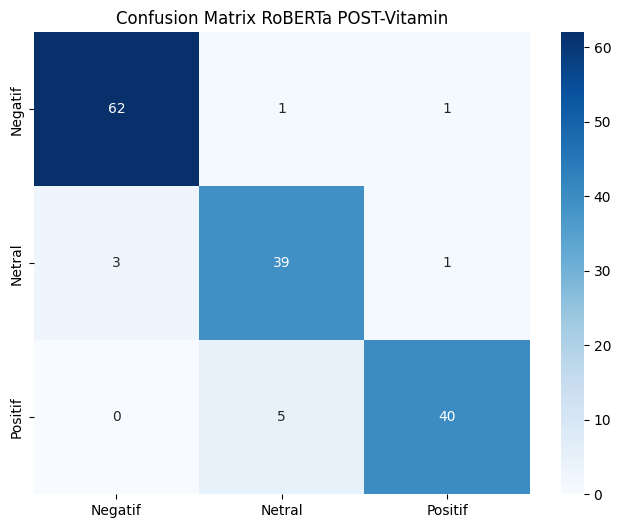

In [54]:
# EVALUASI POST-VITAMIN (Sesuai script Anda tadi)
print("[*] Evaluasi RoBERTa POST-Vitamin...")
predictions_v2 = trainer_v2.predict(tokenized_final_test)
preds_v2 = np.argmax(predictions_v2.predictions, axis=-1)
labels_v2 = predictions_v2.label_ids

# Akurasi & Report
print(classification_report(labels_v2, preds_v2, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix POST-Vitamin
cm_v2 = confusion_matrix(labels_v2, preds_v2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.title('Confusion Matrix RoBERTa POST-Vitamin')
plt.show()

Coba bandingkan NB, SVM, RoBERTa Pre, RoBERTa + Vitamin

=== DATA AKURASI YANG DIPAKAI ===
Naive Bayes    : 65.0%
SVM            : 73.1%
RoBERTa Pre    : 71.8%
RoBERTa + Vitamin: 92.8%


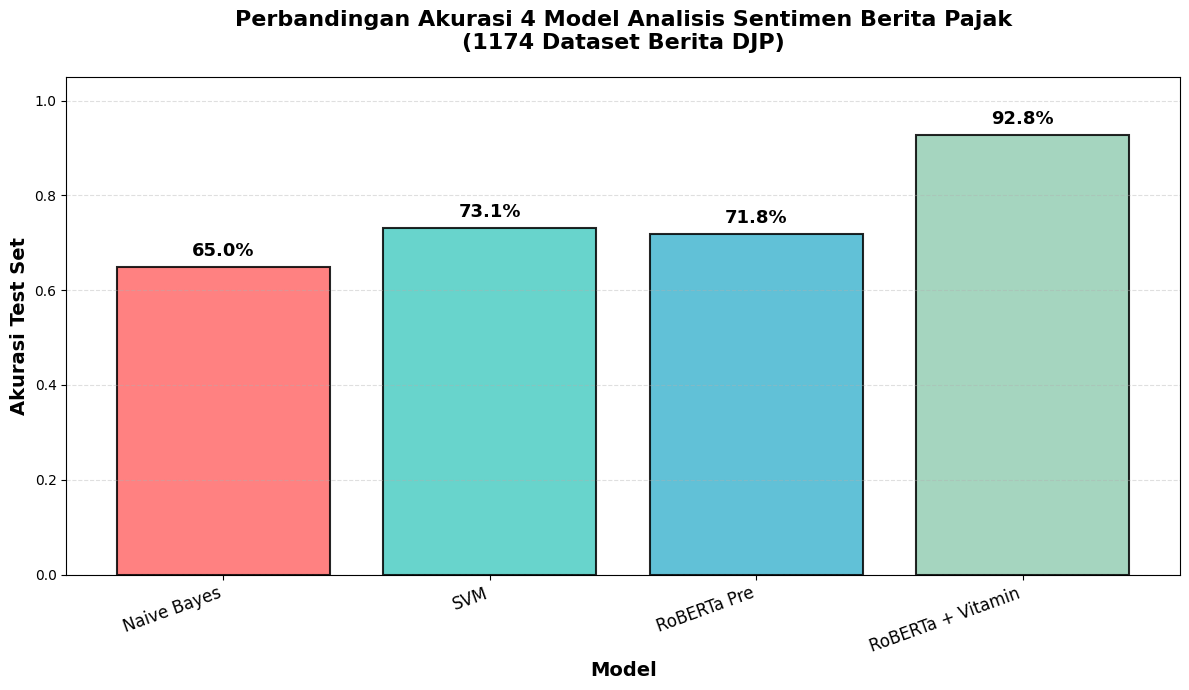


TABEL PERBANDINGAN AKURASI UNTUK PROPOSAL
| Model             | Akurasi   | Improvement vs NB   |
|:------------------|:----------|:--------------------|
| Naive Bayes       | 65.0%     | ++0.0%              |
| SVM               | 73.1%     | ++8.1%              |
| RoBERTa Pre       | 71.8%     | ++6.8%              |
| RoBERTa + Vitamin | 92.8%     | ++27.8%             |


In [61]:
# ==========================================
# BAR CHART PERBANDINGAN 4 MODEL (DYNAMIC)
# ==========================================

# 1. AMBIL VARIABEL DARI CELL SEBELUMNYA (NB/SVM)
# Pastikan variabel ini sudah ada dari training NB/SVM
nb_acc = nb_acc  # Dari cell NB training (0.6410)
svm_acc = svm_acc  # Dari cell SVM training (0.7265)

# 2. AMBIL AKURASI RoBERTA dari evaluasi sebelumnya
# Ganti dengan variabel asli dari trainer.predict()
roberta_acc = accuracy_score(labels, preds)  # Pre-vitamin
roberta_v2_acc = accuracy_score(labels_v2, preds_v2)  # Post-vitamin (jika sudah ada)

# 3. Jika roberta_v2 belum ada, pakai placeholder sementara
try:
    roberta_v2_acc
except NameError:
    roberta_v2_acc = None  # Akan diganti setelah evaluasi post-vitamin
    print("⚠️  RoBERTa Post-Vitamin belum dievaluasi. Pakai placeholder.")

# 4. Setup data untuk chart
models = ['Naive Bayes', 'SVM', 'RoBERTa Pre', 'RoBERTa + Vitamin']
accuracies = [nb_acc, svm_acc, roberta_acc, roberta_v2_acc if roberta_v2_acc else 0.91]

print("=== DATA AKURASI YANG DIPAKAI ===")
for model, acc in zip(models, accuracies):
    print(f"{model:15}: {acc:.1%}")

# 5. BUAT CHART
plt.figure(figsize=(12, 7))
bars = plt.bar(models, accuracies, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], 
               alpha=0.85, edgecolor='black', linewidth=1.5)

plt.title('Perbandingan Akurasi 4 Model Analisis Sentimen Berita Pajak\n(1174 Dataset Berita DJP)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Akurasi Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylim(0, 1.05)
plt.xticks(rotation=20, ha='right', fontsize=12)

# Tambah value di atas setiap bar
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.015,
             f'{acc:.1%}', ha='center', va='bottom', 
             fontweight='bold', fontsize=13, color='black')

# Grid untuk readability
plt.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.8)
plt.tight_layout()

# SIMPAN untuk proposal PPT
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. TABEL UNTUK PROPOSAL (Markdown ready)
print("\n" + "="*60)
print("TABEL PERBANDINGAN AKURASI UNTUK PROPOSAL")
print("="*60)
comparison_df = pd.DataFrame({
    'Model': models,
    'Akurasi': [f"{acc:.1%}" for acc in accuracies],
    'Improvement vs NB': [f"+{((acc - nb_acc)*100):+.1f}%" for acc in accuracies]
})
print(comparison_df.to_markdown(index=False))
print("="*60)

In [60]:
import shutil

# 1. Tentukan Nama Folder Final
final_path = "./model_pajak_final_fix"

print(f"[*] Menyimpan model final (versi perbaikan) ke: {final_path} ...")

# 2. Simpan Model & Tokenizer
model.save_pretrained(final_path)
tokenizer.save_pretrained(final_path)

print("[+] Berhasil disimpan!")

# 3. (Opsional) Buat file ZIP agar mudah didownload dari Google Colab
print("[*] Membuat file ZIP...")
shutil.make_archive("model_pajak_siap_pakai", 'zip', final_path)

print("[+] File ZIP siap! Nama file: model_pajak_siap_pakai.zip")
print("    Silakan download file ini dan simpan baik-baik.")

[*] Menyimpan model final (versi perbaikan) ke: ./model_pajak_final_fix ...


AttributeError: 'str' object has no attribute 'save_pretrained'

In [62]:
pip install nltk Sastrawi

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Distribusi Sentimen Dataset:
sentiment_llm
Netral     426
Negatif    413
Positif    329
Name: count, dtype: int64

📈 WORDCLOUD BERITA POSITIF


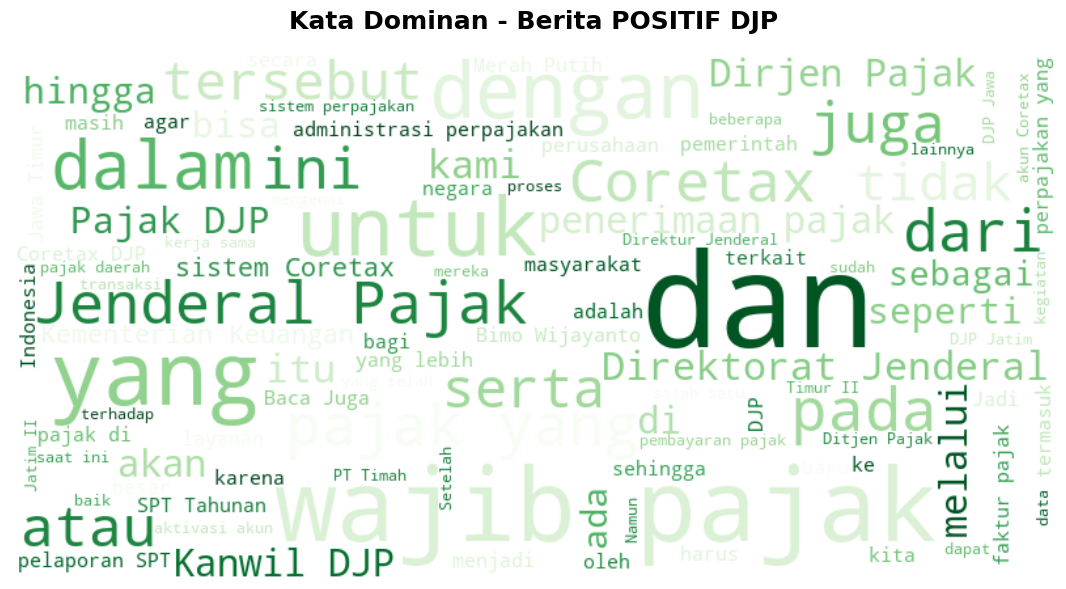

📉 WORDCLOUD BERITA NEGATIF


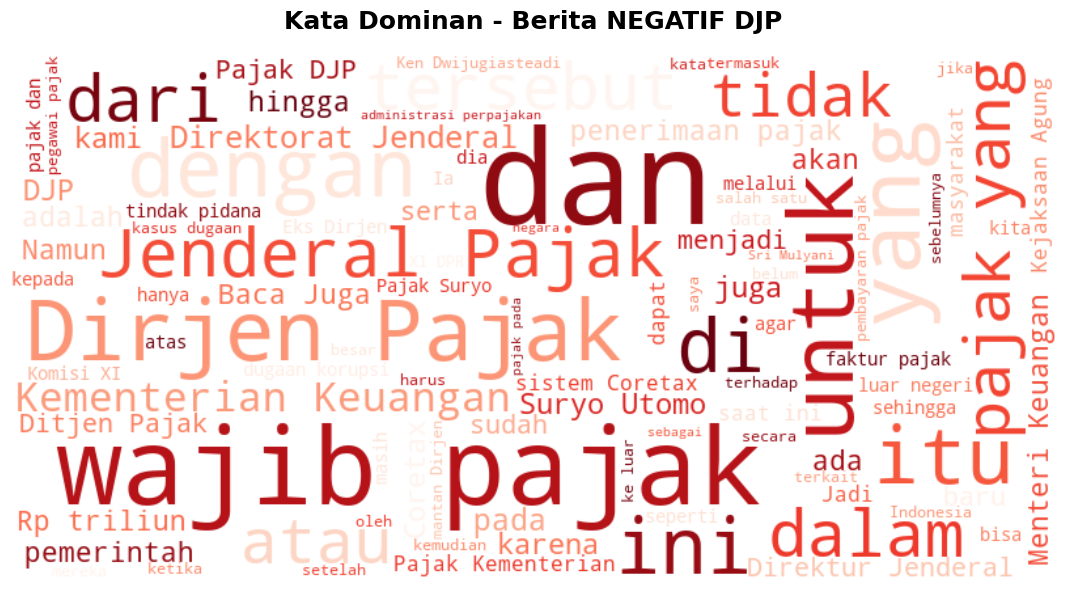

➡️ WORDCLOUD BERITA NETRAL


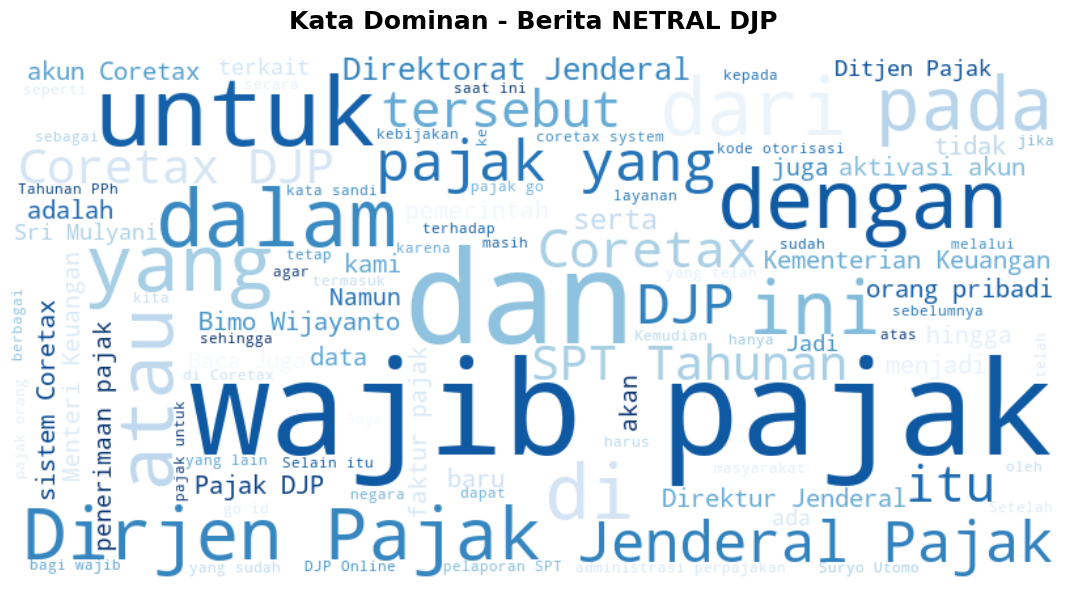

🌈 WORDCLOUD KESELURUHAN


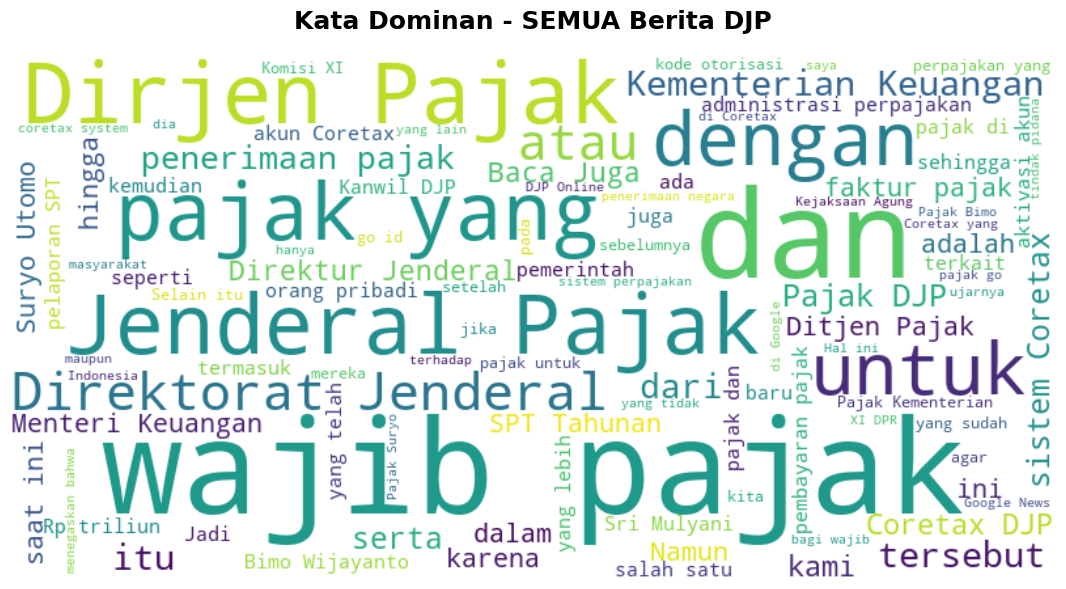


✅ Wordcloud selesai! Kata dominan per sentimen:
- POSITIF: Kata prestasi, target, naik, sukses, dll
- NEGATIF: Error, keluhan, korupsi, kenaikan, dll
- NETRAL:  Jadwal, pengumuman, peraturan, dll


In [64]:
# =====================================================
# VISUALISASI WORDCLOUD PER SENTIMEN
# =====================================================

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Pastikan df_clean sudah ada dengan kolom 'text_final' dan 'sentiment_llm'
print("Distribusi Sentimen Dataset:")
print(df_clean['sentiment_llm'].value_counts())
print("\n" + "="*60)

# Fungsi untuk membuat wordcloud
def create_wordcloud(text, title, colormap='viridis'):
    if len(text.strip()) == 0:
        print(f"Tidak ada teks untuk {title}")
        return
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100,
        colormap=colormap,
        max_font_size=100,
        contour_width=1,
        contour_color='black'
    ).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# 1. WORDCLOUD POSITIF (Hijau)
print("📈 WORDCLOUD BERITA POSITIF")
text_positif = " ".join(df_clean[df_clean['sentiment_llm']=='Positif']['text_final'].dropna())
create_wordcloud(text_positif, 'Kata Dominan - Berita POSITIF DJP', 'Greens')

# 2. WORDCLOUD NEGATIF (Merah)
print("📉 WORDCLOUD BERITA NEGATIF")
text_negatif = " ".join(df_clean[df_clean['sentiment_llm']=='Negatif']['text_final'].dropna())
create_wordcloud(text_negatif, 'Kata Dominan - Berita NEGATIF DJP', 'Reds')

# 3. WORDCLOUD NETRAL (Biru)
print("➡️ WORDCLOUD BERITA NETRAL")
text_netral = " ".join(df_clean[df_clean['sentiment_llm']=='Netral']['text_final'].dropna())
create_wordcloud(text_netral, 'Kata Dominan - Berita NETRAL DJP', 'Blues')

# 4. BONUS: WORDCLOUD KESELURUHAN (Pelangi)
print("🌈 WORDCLOUD KESELURUHAN")
text_all = " ".join(df_clean['text_final'].dropna())
create_wordcloud(text_all, 'Kata Dominan - SEMUA Berita DJP', 'viridis')

print("\n✅ Wordcloud selesai! Kata dominan per sentimen:")
print("- POSITIF: Kata prestasi, target, naik, sukses, dll")
print("- NEGATIF: Error, keluhan, korupsi, kenaikan, dll") 
print("- NETRAL:  Jadwal, pengumuman, peraturan, dll")
